In [498]:
!pip install category_encoders
!pip install dataprep

In [499]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from dataprep.eda import create_report
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from category_encoders import CatBoostEncoder, CountEncoder

In [500]:
pd.set_option('display.max_columns',  None)

# Descritiva

In [501]:
df = pd.read_csv('IML - Regressão - Exemplo.csv')[['name', 'carbody', 'citympg', 'horsepower', 'price']]
display(df.info())
display(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        205 non-null    object 
 1   carbody     205 non-null    object 
 2   citympg     205 non-null    int64  
 3   horsepower  205 non-null    int64  
 4   price       205 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.1+ KB


None

,name,carbody,citympg,horsepower,price
0,alfa-romero giulia,convertible,21,111,13495.0
1,alfa-romero stelvio,convertible,21,111,16500.0


**Descrição das colunas:**

*Identificadores:*
- name: nome do veiculo. Possui informação da marca e modelo.

*Informações da carroceria:*
- carbody:  carroçaria

*Informações do motor:*
- horsepower: potência do motor

*Informações do combustivel:*
- citympg: consumo de combustivel na cidade



*Variável alvo:*:
- price: preço

In [502]:
# verificando marca do carro
df['make'] = df['name'].apply(lambda v: v.split(' ')[0])
df['make'].value_counts()

toyota         31
nissan         17
mazda          15
honda          13
mitsubishi     13
subaru         12
peugeot        11
volvo          11
volkswagen      9
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
isuzu           4
porsche         4
alfa-romero     3
chevrolet       3
jaguar          3
vw              2
maxda           2
renault         2
toyouta         1
vokswagen       1
Nissan          1
mercury         1
porcshce        1
Name: make, dtype: int64

In [503]:
# tratando erros de digitação
df['make'] = df['make'].replace({'toyouta': 'toyota',
    'Nissan': 'nissan',
    'vokswagen': 'volkswagen', 'vw': 'volkswagen',
    'porcshce': 'porsche',
    'maxda': 'mazda'
    })
df['make'].value_counts()

toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
mercury         1
Name: make, dtype: int64

In [504]:
create_report(df)

Output hidden; open in https://colab.research.google.com to view.

In [505]:
df['price'].quantile([
    0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
    0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, .97, 0.99],
    interpolation='lower')

0.00     5118.0
0.05     6189.0
0.10     6649.0
0.15     6938.0
0.20     7349.0
0.25     7788.0
0.30     8013.0
0.35     8499.0
0.40     8949.0
0.45     9549.0
0.50    10295.0
0.55    11248.0
0.60    12440.0
0.65    13499.0
0.70    15250.0
0.75    16503.0
0.80    17450.0
0.85    18420.0
0.90    22470.0
0.95    32250.0
0.97    35056.0
0.99    37028.0
Name: price, dtype: float64

In [506]:
# sera removido marcas com pouco valores
df = df[df['make'].isin(df['make'].value_counts().reset_index().loc[lambda df: df['make'] > 3, 'index'].tolist())]
print(len(df))

193


# Divisão dos dados

In [507]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0, stratify=df[['make']])

# Análise explortatória

In [508]:
px.scatter(df_train, x='make', y='price', color='carbody')

In [509]:
px.scatter(df_train, x='carbody', y='price', hover_data=list(df_train.columns),color='make')

- É possível observar que a marca e a carroceria influencia o preço do veiculo
- Carro da marca buick, porshe, jaguar e mbw sao mais caros
- Para conversiveis e hardtop, que possui menor quantidade, a marca é mais importante para distinguir o preço dos veiculos
- Sedan possui uma amplitude de variacao maior que hatchback
- Não será adicionado wagon e convertible como covariaveis, para nao encontrar padroes errados.

In [510]:
df_train[['horsepower', 'citympg']].corr()

,horsepower,citympg
horsepower,1.000000,-0.790648
citympg,-0.790648,1.000000


In [511]:
px.scatter(df_train, x='horsepower', y='citympg', color='price')

# One Hot Encoder

## Engenharia de recursos

In [512]:
transformer = ColumnTransformer([
   ('scaler', MinMaxScaler(), ['horsepower', 'citympg']),
   ('one_hot',  OneHotEncoder(handle_unknown='ignore', sparse=False), ['carbody',  'make'])
  ])

In [513]:
def get_features_name(transformer):
    from sklearn.compose import ColumnTransformer
    feature_names = []
    if isinstance(transformer, ColumnTransformer):
        feature_names = []
        for name, trans, column, _ in transformer._iter(fitted=True):
            if trans == "drop":
                continue
            elif trans == "passthrough":
                feature_names.extend(column)
            elif not hasattr(trans, "get_feature_names_out"):
                feature_names.extend([f"{name}_{col}" for col in trans.get_feature_names()])
            else:
                feature_names.extend([f"{name}_{col}" for col in trans.get_feature_names_out()])
        return feature_names
    elif not hasattr(transformer, "get_feature_names_out"):
        return transformer.get_feature_names_out()
    else:
        return transformer.get_feature_names()

In [514]:
X_train = transformer.fit_transform(df_train[['horsepower', 'citympg', 'carbody',  'make']])
y_train = df_train['price']
features = get_features_name(transformer)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [515]:
X_test = transformer.transform(df_test[['horsepower', 'citympg', 'carbody',  'make']])
y_test = df_test['price']

## Seleção de modelos

In [516]:
# objetivo com o resultado dos modelos
resultados = pd.DataFrame()

# função que plota os n maiores coeficientes positivos e negativos
def plot_coefs(coefs, n):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  try:
    coefs.nsmallest(n, 'coef').query('coef < 0').sort_values('coef', ascending = False).plot(kind = 'barh', x = 'features', y = 'coef', color = 'red',  title = 'Coeficientes Negativos', legend=False, ax=ax1)
  except:
    pass
  try:
    coefs.nlargest(n, 'coef').query('coef > 0').sort_values('coef', ascending = True).plot(kind = 'barh', x = 'features', y = 'coef', color = 'blue', title = 'Coeficientes Possitivos', legend=False, ax=ax2, xlabel = "")
  except:
    pass
  fig.tight_layout()

def plot_predict(y_test, y_predict):
  df_ = pd.DataFrame({'predict': y_predict, 'real': y_test})
  fig = px.scatter(df_, x='predict', y='real')
  range_axs = (0, df_.max().max())
  fig.update_xaxes(range=range_axs)
  fig.update_yaxes(range=range_axs)
  fig.show()

In [517]:
# treinando modelo
linear = linear_model.LinearRegression(fit_intercept =False).fit(X_train, y_train)
print('intercept = ', linear.intercept_)
# plotando maiores coeficientes
display(pd.DataFrame({'features': features,  'coef': linear.coef_}))

# plotando nota real x nota predita
plot_predict(y_test, y_predict = linear.predict(X_test))

# salvando resultados
resultados = resultados.append(pd.DataFrame({
    'Method': ["Mínimos Quadrados"],
    'MSE': [mean_squared_error(linear.predict(X_test), y_test)],
    'MAE': [mean_absolute_error(linear.predict(X_test), y_test)]
    }))
print(resultados)

intercept =  0.0


,features,coef
0,scaler_horsepower,27226.201958
1,scaler_citympg,1572.199289
2,one_hot_carbody_convertible,9923.271928
3,one_hot_carbody_hardtop,9000.868563
4,one_hot_carbody_hatchback,4266.178190
5,one_hot_carbody_sedan,5722.614613
6,one_hot_carbody_wagon,5536.392018
7,one_hot_make_audi,4431.634697
8,one_hot_make_bmw,10656.465750
9,one_hot_make_buick,14981.472747


              Method           MSE          MAE
0  Mínimos Quadrados  6.277991e+06  1819.178685


<ipython-input-517-70563636560d>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



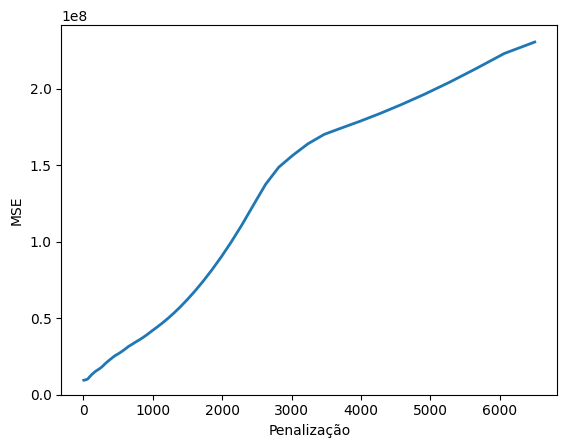

Best Alpha: 6.505603703703703


,features,coef
0,scaler_horsepower,28679.093483
1,scaler_citympg,2181.587907
2,one_hot_carbody_convertible,8658.352918
3,one_hot_carbody_hardtop,7744.018998
4,one_hot_carbody_hatchback,2995.225360
5,one_hot_carbody_sedan,4577.990743
6,one_hot_carbody_wagon,4347.671365
7,one_hot_make_audi,4898.269164
8,one_hot_make_bmw,11034.397462
9,one_hot_make_buick,15380.086978


              Method           MSE          MAE
0  Mínimos Quadrados  6.277991e+06  1819.178685
0              Lasso  6.569578e+06  1890.714022


<ipython-input-518-79164b07fe94>:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [518]:
# treinando modelo
lasso = linear_model.LassoCV(fit_intercept=False, cv=10).fit(X_train,y_train)

# plotando MSE x Penalização
plt.figure()
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1),linewidth=2)
plt.ylim(bottom=0)
plt.xlabel('Penalização')
plt.ylabel('MSE')
plt.show()

# imprimir melhor alpha
print(f'Best Alpha: {lasso.alpha_}')

# plotando maiores coeficientes
display(pd.DataFrame({'features': features,  'coef': lasso.coef_}))

# plotando nota real x nota predita

plot_predict(y_test, y_predict = lasso.predict(X_test))

resultados = resultados.append(pd.DataFrame({
    'Method': ["Lasso"],
    'MSE': [mean_squared_error(lasso.predict(X_test), y_test)],
    'MAE': [mean_absolute_error(lasso.predict(X_test), y_test)]
    }))
print(resultados)

O modelo Lasso apresentou menor MAE e MSE que o modelo linear.

É possível obersar que para valores altos do preço, o erro do modelo é maior para ambos os modelos.


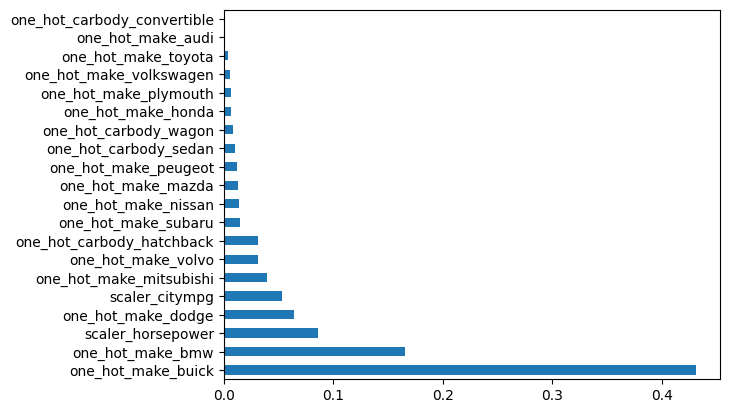

              Method           MSE          MAE
0  Mínimos Quadrados  6.277991e+06  1819.178685
0              Lasso  6.569578e+06  1890.714022
0            XGBoost  1.007528e+07  2220.937475


<ipython-input-519-6f36f2ef43e3>:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [519]:
xgb_model = xgb.XGBRegressor()

# otimização de hiperparametros
parameters = {
    'max_depth': [3, 7, 12],
    'min_child_weight': [5, 10, 20],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.75, 1],
    'n_estimators': [400],
    'eta':[0.01, 0.1, 0.5]
    }

xgb_model_gscv = GridSearchCV(xgb_model, parameters, n_jobs=4, cv=5,scoring=make_scorer(mse,greater_is_better=False))
xgb_model_gscv.fit(X_train, y_train,verbose=0)

# plotando as variaveis mais importantes
feat_importances = pd.Series(xgb_model_gscv.best_estimator_.feature_importances_, index = features)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


resultados = resultados.append(pd.DataFrame({
    'Method': ["XGBoost"],
    'MSE': [mean_squared_error(xgb_model_gscv.predict(X_test), y_test)],
    'MAE': [mean_absolute_error(xgb_model_gscv.predict(X_test), y_test)]
    }))
print(resultados)

In [520]:
# resultados removendo os outliers
filter = (y_test < 25_000)
resultados = pd.DataFrame()
resultados = resultados.append(pd.DataFrame({
    'Method': ["Linear", "Lasso", 'XGBoost'],
    'MSE': [mean_squared_error(linear.predict(X_test[filter]), y_test[filter]), mean_squared_error(lasso.predict(X_test[filter]), y_test[filter]), mean_squared_error(xgb_model_gscv.predict(X_test[filter]), y_test[filter])],
    'MAE': [mean_absolute_error(linear.predict(X_test[filter]), y_test[filter]), mean_absolute_error(lasso.predict(X_test[filter]), y_test[filter]), mean_absolute_error(xgb_model_gscv.predict(X_test[filter]), y_test[filter])]
    }))
print(resultados)

    Method           MSE          MAE
0   Linear  6.160209e+06  1790.374235
1    Lasso  6.448347e+06  1862.353745
2  XGBoost  9.377933e+06  2144.668376


<ipython-input-520-873a96bbfedd>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Removendo outliers, foi possivel observar que o modelo linear apresentou melhores metricas, errando em media 1500.

Porém, o Lasso ainda é uma opção quando se tem poucos dados disponiveis, porque utiliza apenas 3 variaveis para prever.

# CatBoost Encoder

In [521]:
transformer = ColumnTransformer([
   ('scaler', MinMaxScaler(), ['horsepower', 'citympg']),
   ('one_hot',  OneHotEncoder(handle_unknown='ignore', sparse=False), ['carbody',  'make']),
   ('cat_boost',  CatBoostEncoder(handle_unknown='value'), ['carbody',  'make']),
   ('count_encoder',  CountEncoder(handle_unknown='value'), ['carbody',  'make'])
  ])

In [522]:
X_train = transformer.fit_transform(df_train[['horsepower', 'citympg', 'carbody',  'make']], y=df_train['price'])
y_train = df_train['price']
features = get_features_name(transformer)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [523]:
X_test = transformer.transform(df_test[filter][['horsepower', 'citympg', 'carbody',  'make']])
y_test = df_test[filter]['price']

In [524]:
# treinando modelo
lasso = linear_model.LinearRegression(fit_intercept=False).fit(X_train, y_train)

# plotando maiores coeficientes
display(pd.DataFrame({'features': features,  'coef': lasso.coef_}))

# plotando nota real x nota predita
plot_predict(y_train, y_predict = lasso.predict(X_train))
plot_predict(y_test, y_predict = lasso.predict(X_test))

resultados = resultados.append(pd.DataFrame({
    'Method': ["Lasso CatBoost"],
    'MSE': [mean_squared_error(lasso.predict(X_test), y_test)],
    'MAE': [mean_absolute_error(lasso.predict(X_test), y_test)]
    }))
print(resultados)

,features,coef
0,scaler_horsepower,23697.632551
1,scaler_citympg,795.164312
2,one_hot_carbody_convertible,18005.611901
3,one_hot_carbody_hardtop,18657.385635
4,one_hot_carbody_hatchback,-1254.030503
5,one_hot_carbody_sedan,-3229.125743
6,one_hot_carbody_wagon,6482.779710
7,one_hot_make_audi,6877.692377
8,one_hot_make_bmw,15682.192600
9,one_hot_make_buick,19977.577494


           Method           MSE          MAE
0          Linear  6.160209e+06  1790.374235
1           Lasso  6.448347e+06  1862.353745
2         XGBoost  9.377933e+06  2144.668376
0  Lasso CatBoost  5.704702e+06  1790.681417


<ipython-input-524-fcf586f3282f>:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



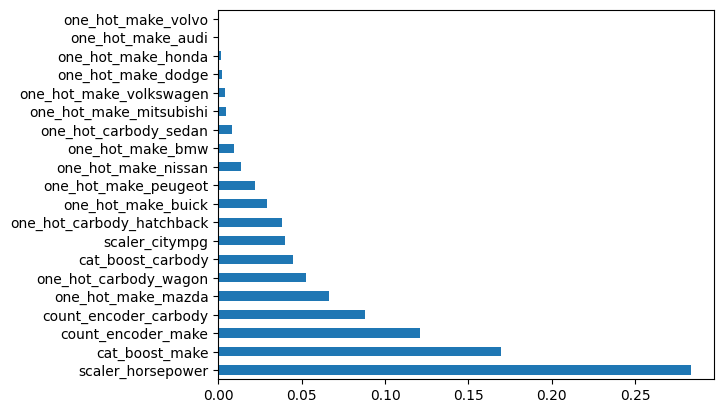

             Method           MSE          MAE
0            Linear  6.160209e+06  1790.374235
1             Lasso  6.448347e+06  1862.353745
2           XGBoost  9.377933e+06  2144.668376
0    Lasso CatBoost  5.704702e+06  1790.681417
0  XGBoost CatBoost  4.235901e+06  1570.240234


<ipython-input-525-8516ea5db9f2>:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [525]:
xgb_model = xgb.XGBRegressor()

# otimização de hiperparametros
parameters = {
    'max_depth': [3, 7, 12],
    'min_child_weight': [5, 10, 20],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.75, 1],
    'n_estimators': [400],
    'eta':[0.01, 0.1, 0.5]
    }

xgb_model_gscv = GridSearchCV(xgb_model, parameters, n_jobs=4, cv=5,scoring=make_scorer(mse,greater_is_better=False))
xgb_model_gscv.fit(X_train, y_train,verbose=0)

# plotando as variaveis mais importantes
feat_importances = pd.Series(xgb_model_gscv.best_estimator_.feature_importances_, index = features)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


resultados = resultados.append(pd.DataFrame({
    'Method': ["XGBoost CatBoost"],
    'MSE': [mean_squared_error(xgb_model_gscv.predict(X_test), y_test)],
    'MAE': [mean_absolute_error(xgb_model_gscv.predict(X_test), y_test)]
    }))
print(resultados)